# PyTorch 2D convolutions
#### Christian Igel, 2023

In [2]:
import torch
import torch.nn as nn

## One input channel, one output, no padding
Let's define a `W`$\times$`W` filter. For the following examples, we do not need a bias parameter.

In [3]:
# Convolution filter is of size W
W = 3
# 1 input (image) channel, 1 output channel, WxW convolution kernel
conv = nn.Conv2d(1, 1, W, bias=False)
print("We just defined:", conv)

We just defined: Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)


Let's look at the kernel dimensions:

In [4]:
# 1 output channel, 1 input channel, 1st dimension = W, 2nd dimension = W
print(conv.weight.shape)

torch.Size([1, 1, 3, 3])


The filter parameters are initialized randomly:

In [5]:
print(conv.weight)

Parameter containing:
tensor([[[[-0.0111,  0.0479,  0.3285],
          [ 0.0354,  0.1842, -0.2094],
          [-0.0090,  0.3259, -0.2223]]]], requires_grad=True)


We can set the parameters as follows:

In [6]:
conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
print(conv.weight)

Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)


Let's define an input (image) `x`. The input is of the same shape as the filter:

In [7]:
x = torch.arange(float(W*W))
x = torch.reshape(x, (1, 1, W, W))
print('Input:\n', x)
print('Sum of all input elements:', torch.sum(x).item())

Input:
 tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
Sum of all input elements: 36.0


Because there is no padding and input and filter have the same size, there is only one valid position for the filter. Accordingly, the result is a tensor with a single value:

In [8]:
c = conv(x)
print('Tensor:', c, 'scalar:', c.item())

Tensor: tensor([[[[36.]]]], grad_fn=<ConvolutionBackward0>) scalar: 36.0


The scalar should be equal to the sum of all input elements (ensure that you understand why).

## One input channel, one output,  padding
Now we add zero-padding such that the input dimensionality is preseved:


In [9]:
conv = nn.Conv2d(1, 1, W, padding=W//2, bias=False)
conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
c = conv(x)
print(c)

tensor([[[[ 8., 15., 12.],
          [21., 36., 27.],
          [20., 33., 24.]]]], grad_fn=<ConvolutionBackward0>)


## Several input channels, one output, no padding
Typically, the input to a convolutional layer consists of several feature maps or channels. For example, consider a 2D input with three channels (e.g., an RGB colour image):

In [10]:
x = torch.arange(float(3*W*W))
x = torch.reshape(x, (1, 3, W, W))
print('Input:', x)
print('Sum of all inputs:', torch.sum(x).item())

Input: tensor([[[[ 0.,  1.,  2.],
          [ 3.,  4.,  5.],
          [ 6.,  7.,  8.]],

         [[ 9., 10., 11.],
          [12., 13., 14.],
          [15., 16., 17.]],

         [[18., 19., 20.],
          [21., 22., 23.],
          [24., 25., 26.]]]])
Sum of all inputs: 351.0


Let's define a convolutional layer that takes three channels as input and produces a single output feature map:

In [11]:
# 3 input (image) channels, 1 output channel, WxW convolution kernel
conv = nn.Conv2d(3, 1, W, bias=False)
conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
print('Weight parameters of convolutional layer:', conv.weight)

Weight parameters of convolutional layer: Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)


Note that there is one filter for each input channel.
The convolutional layer first convolves each input channel with the corresponding filter.
This results in three feature maps, whih are added to give the final result:

In [12]:
c = conv(x)
print('number of filter parameters:', conv.weight.numel(), '\nresult of filtering the input:', c)

number of filter parameters: 27 
result of filtering the input: tensor([[[[351.]]]], grad_fn=<ConvolutionBackward0>)


It is important that the number of parameters and the dimesionality of the result is clear to you.

Now let's apply 1$\times$1 convolutions to our three input channels. Again, we set all filter weights to 1.

In [13]:
# 3 input (image) channels, 1 output channel, 1x1 convolution kernel
conv = nn.Conv2d(3, 1, 1, bias=False)
conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
print(conv.weight)

Parameter containing:
tensor([[[[1.]],

         [[1.]],

         [[1.]]]], requires_grad=True)


This convolutional layer adds the three input feature maps/channels:

In [14]:
c = conv(x)
print(c)

tensor([[[[27., 30., 33.],
          [36., 39., 42.],
          [45., 48., 51.]]]], grad_fn=<ConvolutionBackward0>)


Thus, 1$\times$1 convolutions can be used to compute weighted sums of input feature maps/channels (in our previous example, all weights were set to 1). 

## Several output maps
Typically, convolutional layer produce several feature maps or channels. For example, consider 
extending the previous 1$\times$1 example to two output maps:

In [15]:
# 3 input (image) channels, 2 output channel, 1x1 convolution kernel
conv = nn.Conv2d(3, 2, 1, bias=False)
conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
print(conv.weight)

Parameter containing:
tensor([[[[1.]],

         [[1.]],

         [[1.]]],


        [[[1.]],

         [[1.]],

         [[1.]]]], requires_grad=True)


This layer maps 3 input feature maps to 2 output feature maps, which are identical in our example, because we initialized all filters so that they are identical: 

In [16]:
c = conv(x)
print(c)

tensor([[[[27., 30., 33.],
          [36., 39., 42.],
          [45., 48., 51.]],

         [[27., 30., 33.],
          [36., 39., 42.],
          [45., 48., 51.]]]], grad_fn=<ConvolutionBackward0>)


The first convolutional layer in a network has typically more output feature maps than input channels. Let's assume 3 input channels, 4 output channels of the same dimensionality (i.e., we use padding), and a filter size of 3. For each output channel, we have 3 filter with 9 parameters/weights each. Thus, we have 108 parameters in total:

In [17]:
conv = nn.Conv2d(3, 4, W, padding=W//2, bias=False)
print(conv.weight)
print("Number of parameters:", conv.weight.shape.numel())

Parameter containing:
tensor([[[[-0.0978, -0.0666,  0.0449],
          [ 0.1163,  0.1822, -0.0436],
          [-0.0988, -0.0110, -0.1265]],

         [[-0.0659,  0.1329,  0.1600],
          [-0.0376, -0.0147, -0.1131],
          [ 0.1158,  0.1675,  0.0866]],

         [[-0.1075,  0.0585, -0.1779],
          [-0.0480,  0.1456,  0.1623],
          [-0.1263, -0.1748, -0.1326]]],


        [[[ 0.1291,  0.0409,  0.0957],
          [-0.0771,  0.1332,  0.0777],
          [-0.0206,  0.0112, -0.1564]],

         [[-0.1863, -0.0446, -0.0378],
          [-0.0508, -0.0822,  0.1705],
          [ 0.1407, -0.0674,  0.1549]],

         [[ 0.1624,  0.0402, -0.1826],
          [-0.0009,  0.0404,  0.1909],
          [ 0.0482,  0.0536, -0.1126]]],


        [[[ 0.0174,  0.0838, -0.1572],
          [ 0.0755, -0.1711, -0.1635],
          [-0.0445, -0.1135,  0.1173]],

         [[-0.0867, -0.1494, -0.0077],
          [-0.0898,  0.0467,  0.0658],
          [ 0.0801, -0.1714, -0.0703]],

         [[-0.1896,  0

And here are the resulting feature maps when applied to our input:

In [18]:
c = conv(x)
print(c)

tensor([[[[  0.4052,  -2.2301,  -1.4586],
          [  1.3020,  -3.9445,  -1.1099],
          [  7.2785,   3.3898,   3.2655]],

         [[  4.6553,   7.2357,   2.7207],
          [  2.4673,   6.3246,   4.8529],
          [  4.8839,   5.6430,   1.5160]],

         [[ -6.1424,  -7.5928,  -4.3649],
          [ -7.7255, -13.5576,  -8.5899],
          [ -1.9731,  -9.2857,  -2.6038]],

         [[ -0.8382,   7.2543,   6.1603],
          [  4.4250,  13.1561,   8.7752],
          [  5.9753,   9.3464,   3.3538]]]], grad_fn=<ConvolutionBackward0>)


# Image processing examples
Now we consider a more complex example that involves some basic image transformations. First, we need to import the torch image utilities and matplot for visualization.

In [19]:
import torchvision
from torchvision.io import read_image, ImageReadMode
import matplotlib.pyplot as plt

Let's generate an image and save it in JPEG format. 

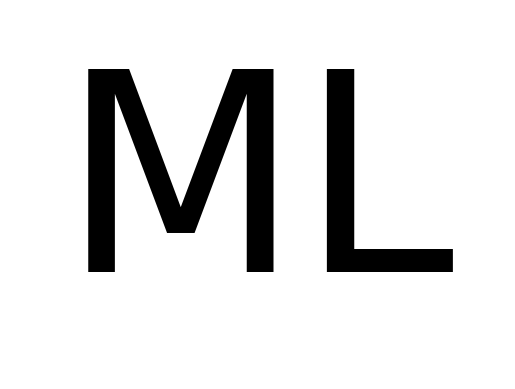

In [20]:
text = "ML"
ax = plt.subplot()
ax.axis('off')
plt.text(0.5, 0.5, text, size=200,
         ha="center", va="center")
plt.savefig(text+".jpg")

Now we load the image again and convert it to grayscale so that we just deal with a single channel. The object returned by `read_image` is a tensor. We cast this tensor to a float tensor.

In [21]:
image = read_image(text+".jpg", mode=ImageReadMode.GRAY).type(torch.FloatTensor)
print("Tensor shape:", image.shape, "type:", image.type(), "min:", image.min().item(), "max:", image.max().item())

Tensor shape: torch.Size([1, 480, 640]) type: torch.FloatTensor min: 0.0 max: 255.0


Let's plot the image. The tensor has the channels (here only one) as the first dimension. For an image, this is typically the last dimension, so we swap the dimensions for plotting:

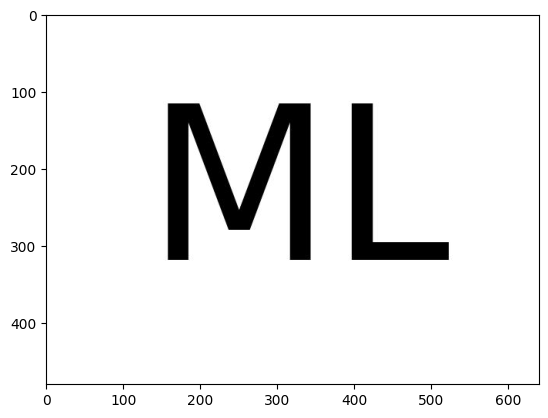

In [22]:
plt.imshow(image.permute(1, 2, 0), cmap='gray');

In order to be process by a layer, the tensor needs  another dimension/axis for enumerating the elements in a batch:

In [23]:
x = image.unsqueeze_(0)  # Add a dimension
print("Shape after adding batch dimension:", x.shape);

Shape after adding batch dimension: torch.Size([1, 1, 480, 640])


Now we apply a simple horizontal gradient filter:

In [24]:
hf = torch.tensor([[[[-1., 1.]]]])  # Define filter
print("Kernel:", hf, "shape:", hf.shape)

conv = nn.Conv2d(1, 1, kernel_size=(1, 2), padding=(0, 1), bias=False)  # Padding only in one dimension needed
conv.weight = torch.nn.Parameter(hf, requires_grad=False)  # Set kernel parameters to predefined filter parameters  
c = conv(x)  # Apply filter
print("Tensor shape:", c.shape, "min:", c.min().item(), "max:", c.max().item())

Kernel: tensor([[[[-1.,  1.]]]]) shape: torch.Size([1, 1, 1, 2])
Tensor shape: torch.Size([1, 1, 480, 641]) min: -255.0 max: 255.0


We do not need a gradient for the kernel parameters, so we can use ``requires_grad=False``. This allows us to use ``c[0.0]`` as a NumPy array in the visualizaiton below. Alternatively, we could use ``c[0,0].detach()`` in the ``imshow`` call.

torch.Size([480, 641])


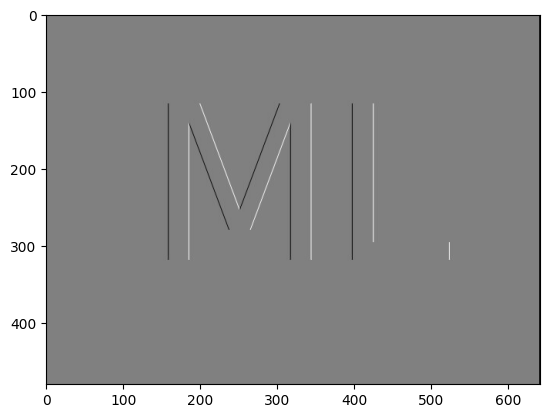

In [25]:
print(c[0,0].shape)
plt.imshow(c[0,0], cmap='gray');

torch.Size([1, 2, 480, 640])
torch.Size([1, 1, 480, 640])
torch.Size([1, 1, 480, 640])
torch.Size([1, 1, 480, 640])


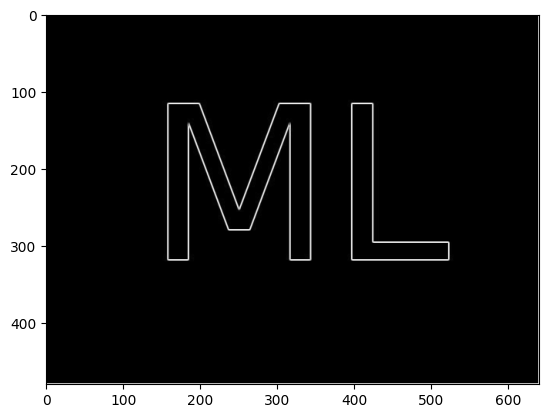

In [39]:
sobel_x = torch.tensor([[[[1., 0., -1.], 
                          [2., 0., -2.], 
                          [1., 0., -1.]]]])

sobel_y = torch.tensor([[[[1., 2., 1.], 
                          [0., 0., 0.], 
                          [-1., -2., -1.]]]])

# Combine the two filters to a single filter
sobel = torch.cat((sobel_x, sobel_y), dim=0)

# Define the convolutional layer
conv = nn.Conv2d(1, 2, kernel_size=3, padding=1, bias=False)

# Set the filter parameters
conv.weight = torch.nn.Parameter(sobel, requires_grad=False)

# Apply the filter
c = conv(x)

# Split the two feature maps
c_x = c[:,0:1,:,:]
c_y = c[:,1:2,:,:]

# Compute square
square_c_x = torch.square(c_x)
square_c_y = torch.square(c_y)

# Compute sqrt of sum for two feature maps
t = torch.sqrt(square_c_x + square_c_y)

plt.imshow(t[0,0], cmap='gray');

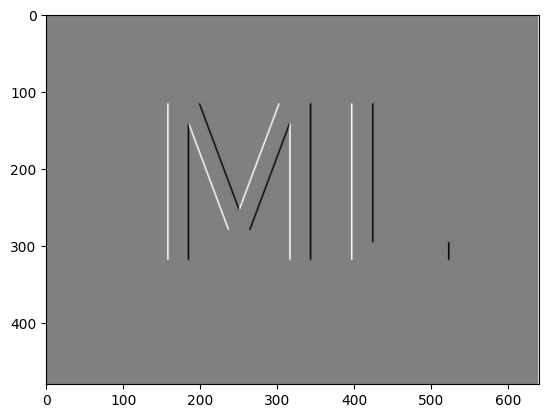

In [40]:
plt.imshow(c_x[0,0], cmap='gray');

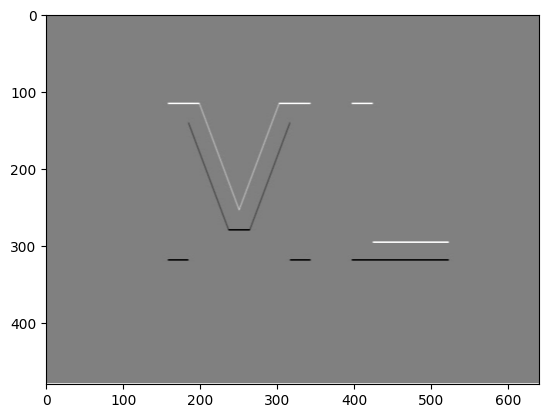

In [41]:
plt.imshow(c_y[0,0], cmap='gray');